In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [98]:
# Load Data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close                             1826 non-null   float64
 1   open                              1826 non-null   float64
 2   high                              1826 non-null   float64
 3   low                               1826 non-null   float64
 4   estimated-transaction-volume-usd  1826 non-null   float64
 5   n-transactions                    1826 non-null   float64
 6   hash-rate                         1826 non-null   float64
 7   difficulty                        1826 non-null   float64
 8   cost-per-transaction              1826 non-null   float64
 9   Gold price                        1826 non-null   float64
 10  output-volume                     1826 non-null   float64
 11  trade-volume                      1826 non-null   f

In [133]:
df.describe()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
count,1826.000000,1826.000000,1826.000000,1826.000000,1.826000e+03,1826.000000,1.826000e+03,1.826000e+03,1826.000000,1826.000000,1.826000e+03,1.826000e+03,1826.000000,1826.000000,1826.000000
mean,15470.656119,15446.307986,15900.046760,14932.582596,2.004009e+09,282361.699343,7.478909e+07,1.034516e+13,72.066568,1377.316553,1.858920e+06,3.828892e+08,6.729910,18.574713,8577.153888
std,16954.387251,16943.040894,17426.130778,16377.809151,2.112128e+09,55605.460107,5.422990e+07,7.524769e+12,58.827950,217.855991,1.334892e+06,4.398635e+08,0.203799,5.753845,9960.120160
min,778.839780,778.839783,822.860239,748.698368,1.121429e+08,124640.000000,2.147763e+06,3.176884e+11,5.612592,867.400000,4.219402e+05,0.000000e+00,6.269000,4.000000,1538.000000
25%,5515.977113,5506.636185,5643.917919,5281.151540,6.858568e+08,241893.500000,2.620610e+07,3.511061e+12,30.678315,1262.775000,1.019258e+06,1.043191e+08,6.614950,18.574713,3402.500000
50%,8660.351137,8646.125856,8844.803315,8348.784186,1.163623e+09,287523.000000,6.206519e+07,7.934713e+12,51.440029,1377.316553,1.553934e+06,2.406228e+08,6.729910,18.574713,5924.000000
75%,14159.005555,14132.352920,14863.570297,13345.497015,2.403180e+09,322992.250000,1.216233e+08,1.686567e+13,97.636480,1536.275000,2.310978e+06,5.018060e+08,6.878675,18.574713,9782.500000
max,67553.948930,67554.840000,68990.900000,66316.000000,1.464262e+10,490644.000000,1.985140e+08,2.504649e+13,300.310549,1888.700000,2.452867e+07,4.956850e+09,7.178600,100.000000,131165.000000


### Helper functions

In [4]:
import yfinance as yf
from datetime import date

def get_new_data(ticker, start_date, end_date=date.today()):
    '''
    Get financial data from Yahoo Finance
    @param ticker: ticker symbol
    @param start_date: start date
    @param end_date: end date
    @return: dataframe of financial data
    '''
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data

def create_dataset(dataset, look_back=1):
    '''
    Convert an array of values into a dataset matrix
    @param data: array of values
    @param look_back: number of previous values to use as input
    @return: dataset matrix
    '''
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def inverse_transform(X, scaler, features=15):
    '''
    Inverse transform the data back to original scale
    @param X: dataset matrix
    @param scaler: scaler object
    @param features: number of features
    @return: dataset matrix
    '''

    # Create an array of zeroes which has as many features as dataset
    extended = np.zeros((len(X), features))
    # Put the predictions from the model in the extended array at the right place
    extended[:, 0:] = X

    # Inverse transform it and select the 1st column.
    return scaler.inverse_transform(extended)[:, 0]

def get_prediction(model, X, scaler):
    '''
    Makes a prediction using a trained model and inverse transforms the predictions
    @param model: trained model
    @param X: data to make predictions on
    @param scaler: scaler used to transform data
    @return: inverse transformed predictions
    '''
    # make predictions
    predictions = model.predict(X)
    # inverse transform predictions
    inv_predictions = inverse_transform(predictions, scaler)
    return inv_predictions

def forecast_accuracy(forecast, actual):
    '''
    Accuracy metrics for a forecast
    @param forecast: forecasted values
    @param actual: actual values
    @return: dictionary of accuracy metrics
    '''
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape': str(round(mape*100, 3))+"%", 'mae': mae, 'rmse': rmse})


Visualization Functions

In [134]:
def plot_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


def pprint(d):
    for key, value in d.items():
        print(f"\t{key}: {value}")

# plot predictions and return a merged dataframe of all the predictions against the actual values
def plot_predictions(predictions, actual):
    pred_df = pd.DataFrame()
    pred_df['Actual'] = actual
    try:
        plt.figure(figsize=(12, 8))
        for idx, prediction in enumerate(predictions):
            plt.plot(prediction, label=f'Model-{idx+1}')
            pred_df[f'Prediction-{idx+1}'] = prediction
    except ValueError as e:
        print('Error:', e)

    # print(pred_df)
    plt.plot(actual, label='Actual')
    plt.legend()
    plt.show()

    return pred_df


def plot_future(past, predictions: list, actual):
    plt.figure(figsize=(15, 8))
    for idx, prediction in enumerate(predictions):
        plt.plot(prediction, label=f'Model-{idx+1}')
    # plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=min(predictions_future.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')


## Data preprocessing and preparation


In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [117]:
# CONSTS
dataset = df.values  # get raw values from dataframe
TIMESTEPS = 30 # n days in the future to predcict
TRAIN_SIZE = int(len(dataset) * 0.8)  # 80% training set
TEST_SIZE = len(dataset) - TRAIN_SIZE  # 20% test set
FEATURES = 14  # number of features

In [118]:
# normalize the dataset
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train, test = dataset[:TRAIN_SIZE, :], dataset[TRAIN_SIZE:len(dataset), :]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, TIMESTEPS)
testX, testY = create_dataset(test, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], TIMESTEPS, FEATURES))
testX = np.reshape(testX, (testX.shape[0], TIMESTEPS, FEATURES))

In [103]:
# Input shape for LSTM : (time steps, features)
input = (trainX.shape[1], trainX.shape[2])
input

(30, 14)

## Build and fit models

In [99]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils.vis_utils import plot_model

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 64)                20224     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


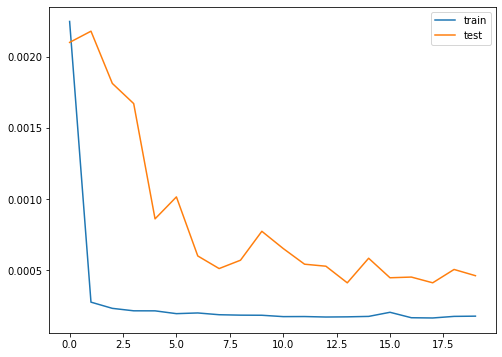

In [104]:
# model1
model = Sequential()

# LSTM layers
model.add(LSTM(64, activation='tanh', input_shape=input))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])
model.summary()

# fit network and plot history
history = model.fit(trainX, trainY, validation_split=0.33, epochs=20, batch_size=32, verbose=0)
plot_history(history)

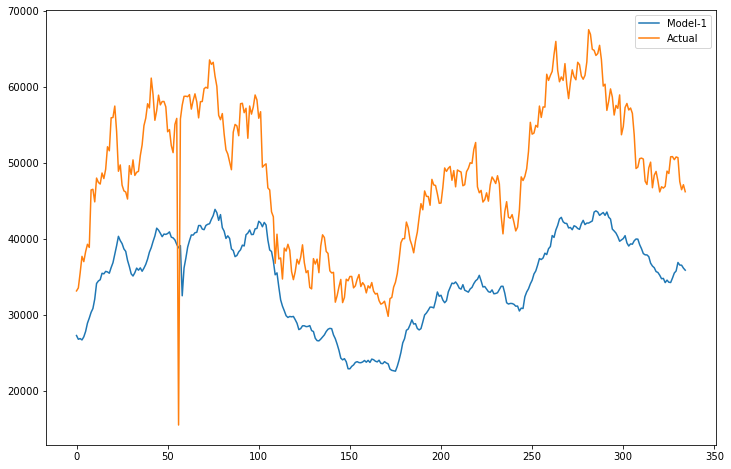

In [135]:
# make predictions: model 1
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverse transform predictions
inv_train_yhat = inverse_transform(trainPredict, scaler)
inv_test_yhat = inverse_transform(testPredict, scaler)
test_period = df[-len(inv_test_yhat):].close.values

# plot predictions
predictions = plot_predictions([inv_test_yhat], test_period)


Epoch 1/20
32/32 [==============================] - 16s 211ms/step - loss: 0.0041 - mean_absolute_error: 0.0451 - val_loss: 0.0018 - val_mean_absolute_error: 0.0267
Epoch 2/20
32/32 [==============================] - 4s 138ms/step - loss: 6.6277e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0011 - val_mean_absolute_error: 0.0226
Epoch 3/20
32/32 [==============================] - 5s 144ms/step - loss: 5.4367e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0012 - val_mean_absolute_error: 0.0271
Epoch 4/20
32/32 [==============================] - 4s 138ms/step - loss: 5.2011e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0011 - val_mean_absolute_error: 0.0204
Epoch 5/20
32/32 [==============================] - 4s 141ms/step - loss: 4.5936e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0010 - val_mean_absolute_error: 0.0214
Epoch 6/20
32/32 [==============================] - 4s 141ms/step - loss: 4.5797e-04 - mean_absolute_error: 0.0145 - val_loss: 8.7885e-04 - val_mean_absolute_error

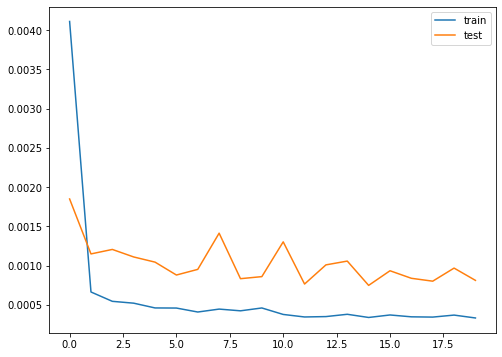

In [106]:
# model2
model2 = Sequential()

# LSTM layers
model2.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=input)) # Input layer

# Hidden layers
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=32, activation='tanh', return_sequences=False))
model2.add(Dropout(0.2))

model2.add(Dense(units=1))  # Output layer

model2.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])
# model2.summary()

history2 = model2.fit(trainX, trainY, validation_split=0.3, epochs=20, batch_size=32)
plot_history(history2)

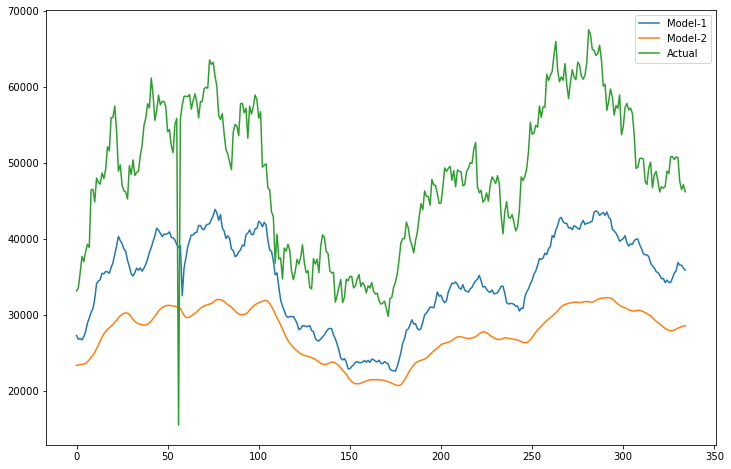

,Actual,Prediction-1,Prediction-2
0,33138.745496,27262.151092,23331.135067
1,33533.900000,26772.058668,23389.079450
2,35514.809100,26860.819027,23444.806913
3,37692.000000,26681.188853,23462.976100
4,36995.561559,27090.148793,23509.216979
...,...,...,...
330,50696.802160,36885.467902,28235.332942
331,47535.309698,36543.974750,28331.792817
332,46471.230000,36529.773730,28438.857686
333,47128.468155,36142.851641,28518.157331


In [136]:
# make predictions
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

# inverse
inv_train_yhat2 = inverse_transform(trainPredict2, scaler)
inv_test_yhat2 = inverse_transform(testPredict2, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2], df[-len(inv_test_yhat):].close.values)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 64)                20224     
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
45/45 [==============================] - 7s 65ms/step - loss: 0.0011 - mean_absolute_error: 0.0236 - val_loss: 0.0334 - val_mean_absolute_error: 0.1694
Epoch 2/20
45/45 [==============================] - 2s 40ms/step - loss: 2.7513e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0164 - val_mean_absolute_error: 0.1095
Epoch 3/20
45/45 [==============================] - 2s 38ms/step - loss: 2.2483e-04 - mean_absolute_error: 0.0098 -

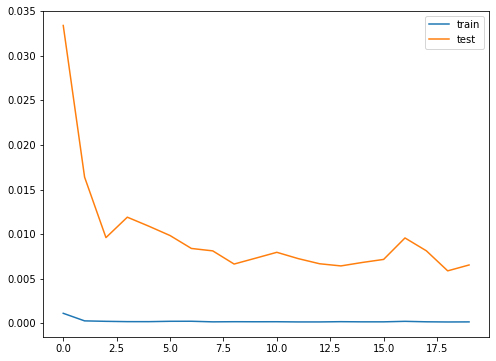

In [119]:
# model3: with validation input
model3 = Sequential()

model3.add(LSTM(64, activation='tanh', input_shape=input))
# model3.add(Dense(64))
model3.add(Dense(1))
# model3.compile(loss='mean_squared_error', optimizer='adam')
model3.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])

model3.summary()
# split test into validation and test
validation_size = int(len(testX) * 0.33)
validationX, _ = testX[:validation_size, :], testX[validation_size:, :]
validationY, _ = testY[:validation_size], testY[validation_size:]

history3 = model3.fit(trainX, trainY, validation_data=(
    validationX, validationY), epochs=20, batch_size=32)

plot_history(history3)

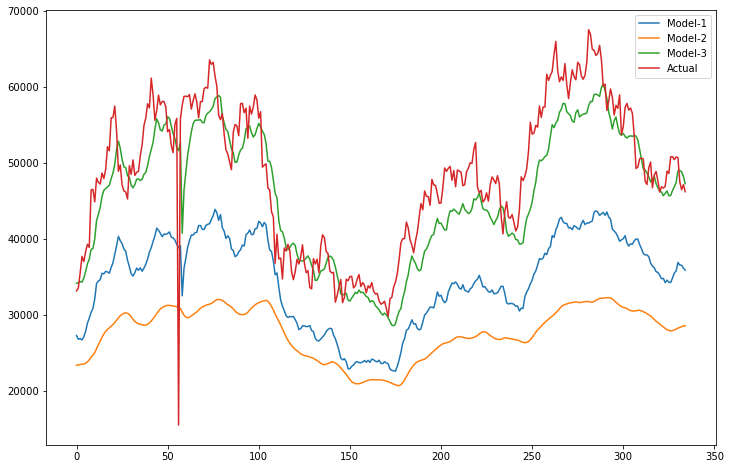

,Actual,Prediction-1,Prediction-2,Prediction-3
0,33138.745496,27262.151092,23331.135067,34139.178386
1,33533.900000,26772.058668,23389.079450,34220.754652
2,35514.809100,26860.819027,23444.806913,34361.881274
3,37692.000000,26681.188853,23462.976100,34300.898079
4,36995.561559,27090.148793,23509.216979,34832.938837
...,...,...,...,...
330,50696.802160,36885.467902,28235.332942,48939.451770
331,47535.309698,36543.974750,28331.792817,49024.140480
332,46471.230000,36529.773730,28438.857686,48842.719258
333,47128.468155,36142.851641,28518.157331,48201.842483


In [137]:
# make predictions
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

# inverse
inv_train_yhat3 = inverse_transform(trainPredict3, scaler)
inv_test_yhat3 = inverse_transform(testPredict3, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3], df[-len(inv_test_yhat):].close.values)

In [111]:
# model4 with limited features
top_predictors = ['close', 'open', 'high', 'low', 'n-transactions',  'SVI', 'estimated-transaction-volume-usd']
# top_predictors = ['close', 'open', 'high', 'low', 'n-transactions', 'cost-per-transaction', 'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df4 = df[top_predictors]


# normalize the dataset
scaler4 = StandardScaler()
# scaler4 = MinMaxScaler(feature_range=(0, 1))
dataset4 = scaler4.fit_transform(df4.values)


# split into train and test sets
train4, test4 =  dataset4[:TRAIN_SIZE, :], dataset4[TRAIN_SIZE:len(dataset4), :]

# reshape into X=t and Y=t+1
trainX4, trainY4 = create_dataset(train4, TIMESTEPS)
testX4, testY4 = create_dataset(test4, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX4 = np.reshape(trainX4, (trainX4.shape[0], TIMESTEPS, len(top_predictors)-1))
testX4 = np.reshape(testX4, (testX4.shape[0], TIMESTEPS, len(top_predictors)-1))


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 64)                18176     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
30/30 [==============================] - 6s 62ms/step - loss: 0.0223 - val_loss: 0.0072
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 4/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 5/20
30/30 [==============================]

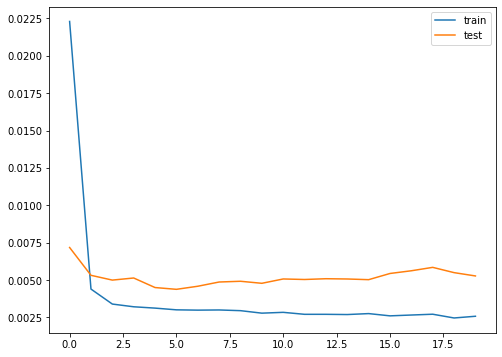

In [112]:
# since model3 performed the best, we will use it for model4
model4 = Sequential()

model4.add(LSTM(64, activation='tanh', input_shape=(trainX4.shape[1], trainX4.shape[2])))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')
# model3.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])

model4.summary()
# history4= model4.fit(trainX4, trainY4, validation_data=(X_val,y_val), epochs=20, batch_size=32)
history4= model4.fit(trainX4, trainY4, validation_split=.33, epochs=20, batch_size=32)

plot_history(history4)


In [ ]:
# make predictions
trainPredict4 = model4.predict(trainX4)
testPredict4 = model4.predict(testX4)

# inverse
inv_train_yhat4 = inverse_transform(trainPredict4, scaler4, len(top_predictors))
inv_test_yhat4 = inverse_transform(testPredict4, scaler4, len(top_predictors))

Finally, lets plot and evaluate the predictions made by each model on the validation data

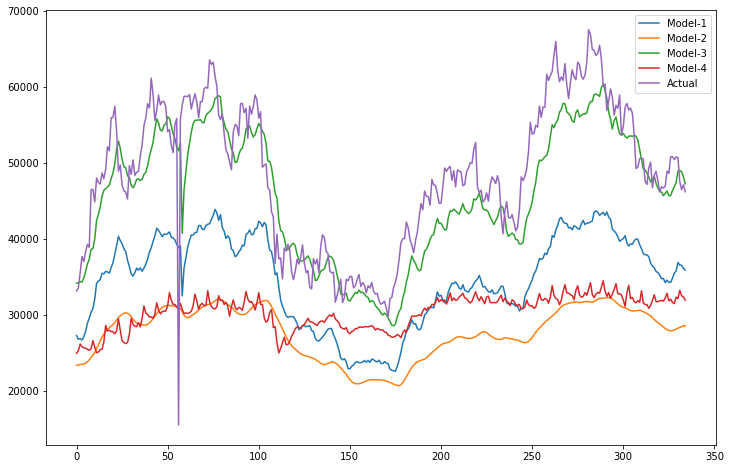

,Actual,Prediction-1,Prediction-2,Prediction-3,Prediction-4
0,33138.745496,27262.151092,23331.135067,34139.178386,24924.548435
1,33533.900000,26772.058668,23389.079450,34220.754652,25248.440267
2,35514.809100,26860.819027,23444.806913,34361.881274,26127.497013
3,37692.000000,26681.188853,23462.976100,34300.898079,25795.333991
4,36995.561559,27090.148793,23509.216979,34832.938837,25648.212469
...,...,...,...,...,...
330,50696.802160,36885.467902,28235.332942,48939.451770,32127.170513
331,47535.309698,36543.974750,28331.792817,49024.140480,33232.312537
332,46471.230000,36529.773730,28438.857686,48842.719258,32501.631074
333,47128.468155,36142.851641,28518.157331,48201.842483,32353.930660


In [139]:
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3,
                  inv_test_yhat4], df[-len(inv_test_yhat):].close.values)

We can see from the plot above, that;
 - Model 1, which was trained without validation data, performed relatively good.
 - Model 2, however, had the worst performance, considering it has the most number of layers and parameters. It had the worst non-linear curve
 - Model 3 has the best curve that follows along the actual values, this could be because it was trained with validation data.
 - Model 4 seems to have difficulties understanding the training data.

In [140]:
print("Model 1:")
pprint(forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values))
print("Model 2:")
pprint(forecast_accuracy(inv_test_yhat2, df[-len(inv_test_yhat2):].close.values))
print("Model 3:")
pprint(forecast_accuracy(inv_test_yhat3, df[-len(inv_test_yhat3):].close.values))
print("Model 4:")
pprint(forecast_accuracy(inv_test_yhat4, df[-len(inv_test_yhat4):].close.values))

Model 1:
	mape: 28.503%
	mae: 13911.62262989094
	rmse: 14647.05997182876
Model 2:
	mape: 42.111%
	mae: 20832.630731911875
	rmse: 21872.745735308425
Model 3:
	mape: 8.382%
	mae: 3893.6240464809307
	rmse: 5001.534256935159
Model 4:
	mape: 35.647%
	mae: 18137.411227889974
	rmse: 19856.989366623297


Visualizing the RMSE & MAE for each model to have a better understanding about which model has the best evaluation metrics

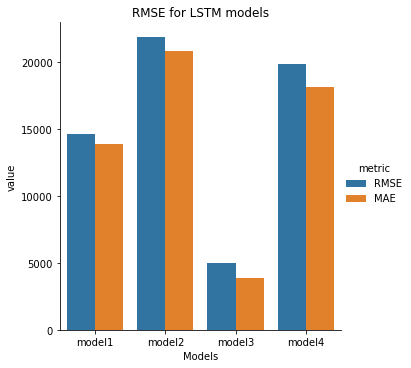

In [141]:
m1 =forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values)
m2 = forecast_accuracy(inv_test_yhat2, df[-len(inv_test_yhat2):].close.values)
m3 = forecast_accuracy(inv_test_yhat3, df[-len(inv_test_yhat3):].close.values)
m4 = forecast_accuracy(inv_test_yhat4, df[-len(inv_test_yhat4):].close.values)

metrics = pd.DataFrame(data={'model': ['model1', 'model2', 'model3', 'model4'],
                          'RMSE': [m1['rmse'], m2['rmse'], m3['rmse'], m4['rmse']],
                          'MAE': [m1['mae'], m2['mae'], m3['mae'], m4['mae']]
                          }
                    )
metrics['RMSE'] = metrics['RMSE'].astype(float)
metrics['MAE'] = metrics['MAE'].astype(float)

metrics = pd.melt(metrics, id_vars="model")
metrics.columns = ['model', 'metric', 'value']

sns.factorplot(x='model', y='value', hue='metric', data=metrics, kind='bar')
plt.xlabel("Models")
plt.title('RMSE for LSTM models')
plt.show()

## Visualize each model in graphs

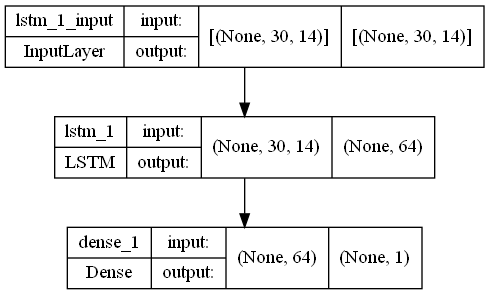

In [41]:
plot_model(model, show_shapes=True, show_layer_names=True)

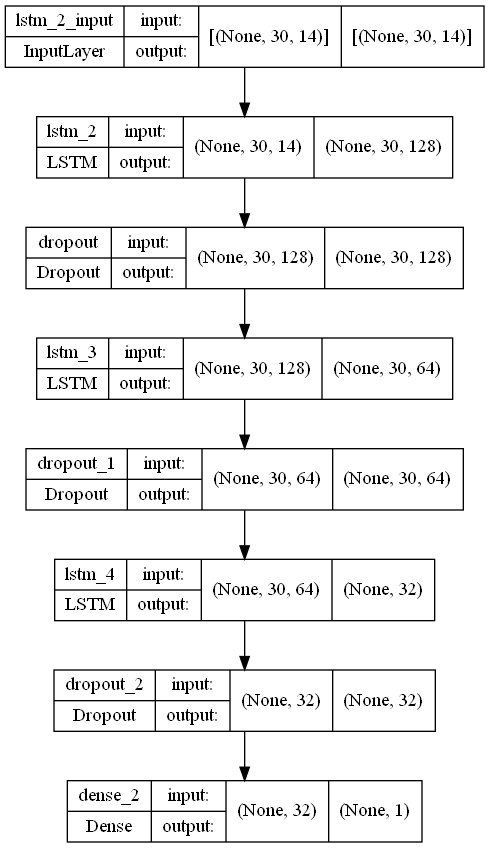

In [42]:
plot_model(model2, show_shapes=True, show_layer_names=True)

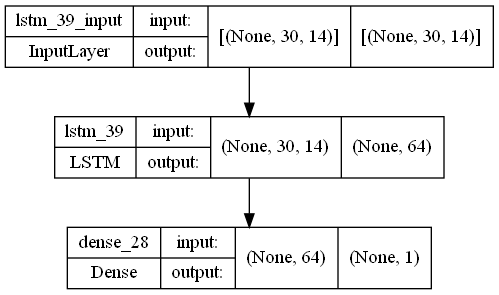

In [131]:
plot_model(model3, show_shapes=True, show_layer_names=True)

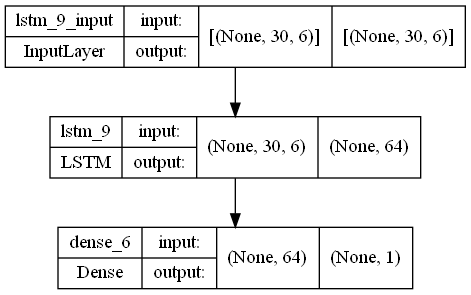

In [44]:
plot_model(model4, show_shapes=True, show_layer_names=True)

## Now lets try to make future predictions

In [34]:
# Get the new/current financial data
yf_df = get_new_data('BTC-USD', '2020-12-31') 

In [35]:
from keras.models import load_model

# loading the best model that was saved
saved_model = load_model('./saved_models/model3-5.756.h5')
saved_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                20224     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(df.index[-1], periods=TIMESTEPS, freq='1d').tolist()

# make a prediction on based on the past 30 days
saved_yhat = get_prediction(saved_model, testX[-TIMESTEPS:], scaler)

# save the prediction to a dataframe
predictions_future = pd.DataFrame(saved_yhat, columns=['Prediction']).set_index(pd.Series(datelist_future))

# get the future closing prices and join the predictions
predictions_future['Actual'] = yf_df.loc[min(predictions_future.index):max(predictions_future.index)].Close


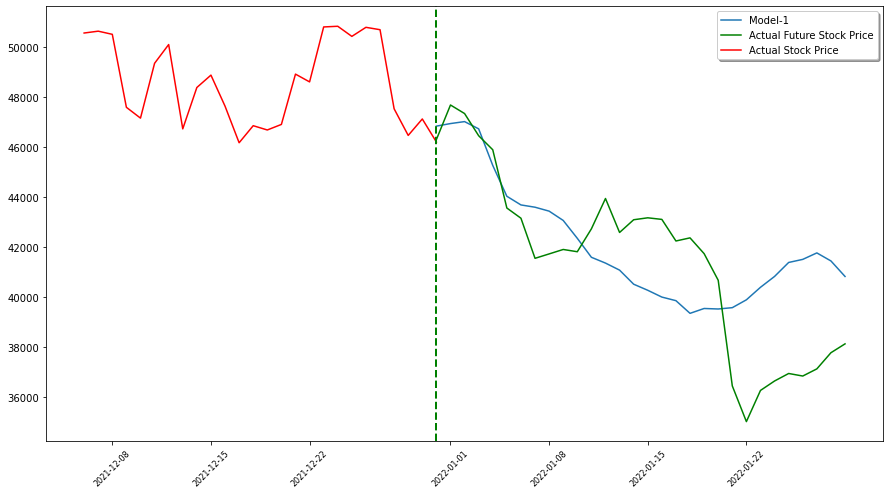

In [125]:
plot_future(df[1800:].close, [predictions_future.Prediction], predictions_future.Actual)

We can see, the model was able to follow the future pattern with little error, which is not bad (not the best curve, but its pretty accurate)

{'mape': '5.756%', 'mae': 2263.25784006576, 'rmse': 2696.1419799978044}

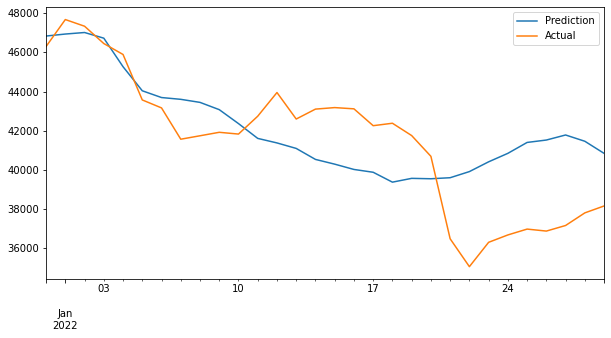

In [126]:
predictions_future.plot(figsize=(10, 5), label='Predicted Stock Price')
forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])

In [127]:
# save model with the MAPE score
def save_model(model, model_name):
    model.save(f'./saved_models/{model_name}.h5')
    print(f'Model saved as {model_name}.h5')

In [ ]:
# mape = forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])['mape'].split("%")[0]
# save_model(model3, f'model3-{mape}')

Model saved as model3-16.054.h5


Lets see what differnce, the `significant features` against all the features.

In [128]:
# make a prediction on based on the past 30 days
predictions_future4 = model4.predict(testX4[-TIMESTEPS:])
predictions_future4 = inverse_transform(predictions_future4, scaler4, len(top_predictors))

# save the prediction to a dataframe
predictions_future4 = pd.DataFrame(predictions_future4, columns=['Prediction']).set_index(pd.Series(datelist_future))
predictions_future4['Actual'] = yf_df.loc[min(predictions_future4.index):max(predictions_future4.index)].Close

Model with significant variables :  {'mape': '22.392%', 'mae': 9532.7613762176, 'rmse': 10206.057959745134}
Model with all variables :  {'mape': '5.756%', 'mae': 2263.25784006576, 'rmse': 2696.1419799978044}


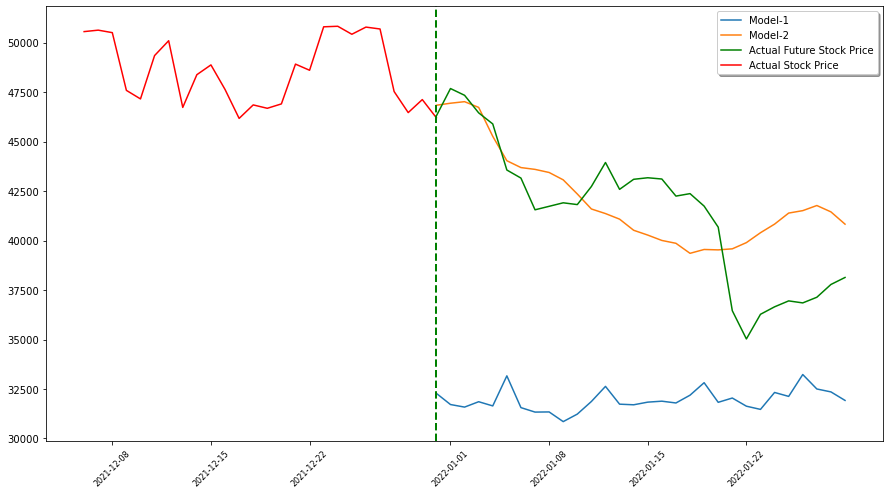

In [143]:
plot_future(df[1800:].close, [predictions_future4.Prediction,predictions_future.Prediction], predictions_future4.Actual)
print("Model with significant variables : ", forecast_accuracy(predictions_future4['Prediction'], predictions_future4['Actual']))
print("Model with all variables : ", forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual']))